c:\Users\Orhan Bayrak\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


X matrix: (1000, 49152)
Clusters: {0, 1}   ( -1 = noise )


c:\Users\Orhan Bayrak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Orhan Bayrak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


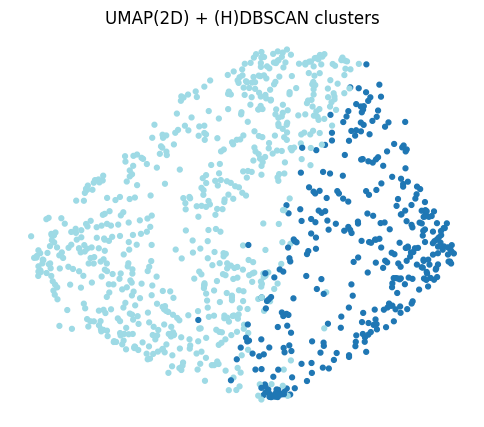

Cluster 0: 338 samples, examples: ['C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_9059.png', 'C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_9060.png', 'C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_9061.png']
Cluster 1: 662 samples, examples: ['C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_906.png', 'C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_9062.png', 'C:\\Users\\Orhan Bayrak\\Downloads\\cat_data\\cat_9063.png']


In [ ]:
import os, numpy as np
from PIL import Image
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import shutil
import matplotlib.pyplot as plt
import umap

# HDBSCAN
try:
    import hdbscan
    HAVE_HDBSCAN = True
except ImportError:
    HAVE_HDBSCAN = False

#Data vectorize
folder = r"C:\Users\Orhan Bayrak\Downloads\cat_data"
size = (128, 128)

paths, X_list = [], []
for fn in sorted(os.listdir(folder)):
    if fn.lower().endswith(('.jpg', '.jpeg', '.png')):
        p = os.path.join(folder, fn)
        try:
            img = Image.open(p).convert("RGB").resize(size, Image.BILINEAR)
            arr = np.asarray(img, dtype=np.float32) / 255.0      
            vec = arr.reshape(-1)                               
            X_list.append(vec); paths.append(p)
        except Exception as e:
            print("skip:", p, e)

X = np.stack(X_list, axis=0)   
print("X matrix:", X.shape)

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

# 3) UMAP: 2B for visualization
umap_vis = umap.UMAP(n_components=2, n_neighbors=200, min_dist=0.01, metric="correlation")
Z2 = umap_vis.fit_transform(X_scaled)   # (N,2)


umap_clu = umap.UMAP(n_components=2, n_neighbors=200, min_dist=0.001, metric="correlation")
Z10 = umap_clu.fit_transform(X_scaled)  # (N,10)

if HAVE_HDBSCAN:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=None, metric="correlation")
    labels = clusterer.fit_predict(Z10)    # -1 = gürültü/noise
else:
    clusterer = DBSCAN(eps=0.5, min_samples=8, metric="correlation")
    labels = clusterer.fit_predict(Z10)    # -1 = gürültü/noise

print("Clusters:", set(labels.tolist()), "  ( -1 = noise )")

# 5) Cluster visualization
plt.figure(figsize=(6,5))
scatter = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap='tab20')
plt.title("UMAP(2D) + (H)DBSCAN clusters")
plt.axis('off')
plt.show()

from collections import defaultdict
clusters = defaultdict(list)
for idx, c in enumerate(labels):
    clusters[int(c)].append(idx)

for c, idxs in clusters.items():
    if c == -1: continue
    print(f"Cluster {c}: {len(idxs)} samples, examples:", [paths[i] for i in idxs[:3]])

cluster_index_lists = dict(clusters)

In [ ]:
from collections import Counter

label_counts = Counter(labels.tolist())
n_total = len(labels)
n_noise = int(label_counts.get(-1, 0))
noise_ratio = n_noise / n_total if n_total else 0.0

print("Cluster counts:", dict(label_counts))
print(f"Total: {n_total}, Noise: {n_noise} ({noise_ratio:.1%})")


Cluster counts: {0: 635, 1: 365}
Total: 1000, Noise: 0 (0.0%)


In [ ]:
import matplotlib.pyplot as plt
import math

def show_cluster_examples(paths, labels, cluster_id, max_images=12, thumb=(128,128)):
    idxs = [i for i,l in enumerate(labels) if l == cluster_id]
    if not idxs:
        print(f"Cluster {cluster_id} is empty.")
        return
    
    n = min(len(idxs), max_images)
    cols = 4
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(cols*1.3, rows*1.3), dpi=150)
    fig.suptitle(f"Cluster {cluster_id} (n={len(idxs)})", y=0.98)

    for j,i in enumerate(idxs[:n], start=1):
        ax = plt.subplot(rows, cols, j)
        img = Image.open(paths[i]).convert("RGB").resize(thumb)
        ax.imshow(img); ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
for c in sorted(set(labels)):
    if c == -1:
        continue  # noise skip
    show_cluster_examples(paths, labels, c, max_images=12)

In [ ]:
try:
    import hdbscan
    HAVE_HDBSCAN = True
except ImportError:
    HAVE_HDBSCAN = False

#1)GRAYSCALE 
def load_grayscale_matrix(folder, size=(128,128)):
    paths, X_list = [], []
    for fn in sorted(os.listdir(folder)):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
            p = os.path.join(folder, fn)
            try:
                img = Image.open(p).convert("L").resize(size, Image.BILINEAR)  # GRAYSCALE (L)
                arr = np.asarray(img, dtype=np.float32) / 255.0              # (H,W) ∈ [0,1]
                vec = arr.reshape(-1)                                        # düzleştir
                X_list.append(vec); paths.append(p)
            except Exception as e:
                print("skip:", p, e)
    X = np.stack(X_list, axis=0) if X_list else np.zeros((0, size[0]*size[1]), dtype=np.float32)
    return X, paths

#2) SCALING + UMAP 
def run_umap_embeddings(X, seed=42, n_components_clu=10, n_neighbors_clu=20, min_dist_clu=0.001,
                        n_components_vis=2, n_neighbors_vis=15, min_dist_vis=0.0):
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_scaled = scaler.fit_transform(X)

    umap_clu = umap.UMAP(n_components=n_components_clu, n_neighbors=n_neighbors_clu,
                         min_dist=min_dist_clu, metric="correlation", random_state=seed)
    Z_clu = umap_clu.fit_transform(X_scaled)

    umap_vis = umap.UMAP(n_components=n_components_vis, n_neighbors=n_neighbors_vis,
                         min_dist=min_dist_vis, metric="correlation", random_state=seed)
    Z_vis = umap_vis.fit_transform(X_scaled)

    return Z_clu, Z_vis

#3) CLUSTERING
def cluster_embedding(Z_clu, min_cluster_size=8, min_samples=None, dbscan_eps=0.5, dbscan_min_samples=8):
    if HAVE_HDBSCAN:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples, metric="correlation")
        labels = clusterer.fit_predict(Z_clu)
    else:
        clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric="correlation")
        labels = clusterer.fit_predict(Z_clu)
    return labels

#4) LARGEST CLUSTER
def largest_cluster(labels):
    # except noise(-1)
    vals, counts = np.unique(labels, return_counts=True)
    best_c, best_n = None, -1
    for c, n in zip(vals, counts):
        if c == -1:  # skip noise
            continue
        if n > best_n:
            best_c, best_n = int(c), int(n)
    return best_c, best_n

import json

#5)SAVE AS PDF
from matplotlib.backends.backend_pdf import PdfPages
def save_clusters_to_pdf(paths, labels, out_pdf="clusters_report.pdf", max_images=16, thumb=(128,128),
                         params=None):
    clusters = sorted(set(labels))
    with PdfPages(out_pdf) as pdf:
        import collections
        cnt = collections.Counter(labels.tolist())

        # Özet sayfası
        fig = plt.figure(figsize=(6,5), dpi=150)
        plt.title("Cluster Summary + Parameters", fontsize=10)

        txt = "\n".join([f"Cluster {c}: {cnt[c]}" for c in sorted(cnt) if c != -1] + [f"Noise (-1): {cnt.get(-1,0)}"])
        if params:
            txt = "Parameters:\n" + json.dumps(params, indent=2) + "\n\n" + txt

        plt.text(0.05, 0.95, txt, va='top', family='monospace', fontsize=8)
        plt.axis('off'); pdf.savefig(fig); plt.close(fig)

        #CLUSTER PAGES
        for c in clusters:
            if c == -1:  
                continue
            idxs = [i for i,l in enumerate(labels) if l == c][:max_images]
            if not idxs: 
                continue
            cols = 4
            rows = math.ceil(len(idxs)/cols)
            fig = plt.figure(figsize=(cols*2.2, rows*2.2), dpi=150)
            fig.suptitle(f"Cluster {c} (n={sum(labels==c)})", y=0.98)
            for j,i in enumerate(idxs, start=1):
                ax = plt.subplot(rows, cols, j)
                try:
                    img = Image.open(paths[i]).convert("L").resize(thumb, Image.BILINEAR)
                    ax.imshow(img, cmap='gray'); ax.axis("off")
                except:
                    ax.text(0.5,0.5,"load error",ha="center",va="center"); ax.axis("off")
            plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
    print(f"PDF kaydedildi: {out_pdf}")


#6)SAVE AS CSV
import pandas as pd
def export_biggest_cluster(paths, labels, Z_vis, out_csv="umap_biggest_cluster.csv",
                           copy_dir=None, params=None):
    big_c, big_n = largest_cluster(labels)
    if big_c is None:
        print("No clusters found (only noise).")
        return None, None
    idxs = [i for i,l in enumerate(labels) if l == big_c]
    df = pd.DataFrame({
        "filepath": [paths[i] for i in idxs],
        "cluster": [int(big_c)] * len(idxs),
        "umap_x": Z_vis[idxs, 0],
        "umap_y": Z_vis[idxs, 1],
    })
    df.to_csv(out_csv, index=False)
    print(f"En büyük küme: {big_c} (n={big_n}). CSV kaydedildi: {Path(out_csv).resolve()}")

    # Save parameters
    if params:
        with open(out_csv.replace(".csv", "_params.json"), "w") as f:
            json.dump(params, f, indent=2)
        print(f"Parametreler kaydedildi: {out_csv.replace('.csv', '_params.json')}")

    if copy_dir:
        Path(copy_dir).mkdir(parents=True, exist_ok=True)
        for p in df["filepath"]:
            try:
                shutil.copy2(p, Path(copy_dir) / Path(p).name)
            except Exception as e:
                print("copy fail:", p, e)
        print(f"Kümeye ait görseller kopyalandı: {Path(copy_dir).resolve()}")
    return big_c, idxs

In [ ]:
# Parameter dict
run_params = {
  "umap_vis": {"n_components": 2,  "n_neighbors": 500, "min_dist": 0.01},
  "umap_clu": {"n_components": 2, "n_neighbors": 500, "min_dist": 0.01},
  "metric":"correlation"
}



save_clusters_to_pdf(paths, labels,
                     out_pdf="cat_clusters_grayscale.pdf",
                     max_images=16,
                     thumb=(128,128),
                     params=run_params)
""""""""""
big_c, idxs = export_biggest_cluster(paths, labels, Z2,
                                     out_csv="umap_biggest_cluster.csv",
                                     copy_dir="largest_cluster_samples",
                                     params=run_params)
"""""""""

PDF kaydedildi: cat_clusters_grayscale.pdf


'"\nbig_c, idxs = export_biggest_cluster(paths, labels, Z2,\n                                     out_csv="umap_biggest_cluster.csv",\n                                     copy_dir="largest_cluster_samples",\n                                     params=run_params)\n'

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

def save_single_cluster_pdf(paths, labels, cluster_id, out_pdf="largest_cluster.pdf", thumb=(128,128), per_page=20):
    idxs = [i for i,l in enumerate(labels) if l == cluster_id]
    if not idxs:
        print(f"Cluster {cluster_id} empty.")
        return
    
    with PdfPages(out_pdf) as pdf:
        n = len(idxs)
        for start in range(0, n, per_page):
            subset = idxs[start:start+per_page]
            cols = 5
            rows = math.ceil(len(subset)/cols)
            fig = plt.figure(figsize=(cols*2.2, rows*2.2), dpi=150)
            fig.suptitle(f"Cluster {cluster_id} (images {start+1}-{start+len(subset)} of {n})", y=0.98)

            for j,i in enumerate(subset, start=1):
                ax = plt.subplot(rows, cols, j)
                try:
                    img = Image.open(paths[i]).convert("L").resize(thumb, Image.BILINEAR)
                    ax.imshow(img, cmap="gray")
                    ax.axis("off")
                except:
                    ax.text(0.5,0.5,"load error",ha="center",va="center"); ax.axis("off")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
    print(f"PDF kaydedildi: {Path(out_pdf).resolve()}")


In [ ]:
# Largest cluster No.=>as X
cluster_id=X
save_single_cluster_pdf(paths, labels, cluster_id, out_pdf="cluster1_all_images.pdf")

PDF kaydedildi: C:\Users\Orhan Bayrak\Desktop\UGR Internship\cluster1_all_images.pdf
